In [1]:
# standard python utilities
import os
from os.path import join, dirname, basename
import glob
import sys
import time
import pandas as pd
import numpy as np

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir
ghb_dir = gwfm_dir+'/GHB_data'

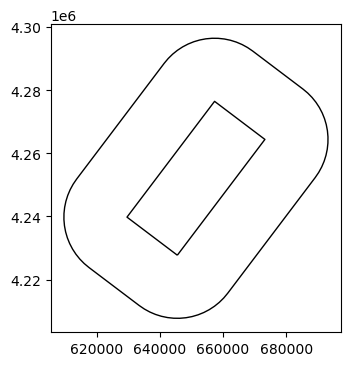

In [3]:
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(join(gwfm_dir,'DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp'))

fig,ax= plt.subplots(figsize =(4,4))
m_domain.plot(ax=ax,edgecolor = 'black', color = 'none')
buffer = 2e4
m_domain.buffer(buffer).plot(ax=ax,edgecolor = 'black', color = 'none')

# buffer domain in order to include boundary observations to influence water table elevations at the model edge
domain_buffered = gpd.GeoDataFrame(data = m_domain.copy(), geometry = m_domain.buffer(buffer))

In [4]:
# m_domain = m_domain.to_crs('epsg:3310')

## Continuous DWR Groundwater data

In [5]:
# con_stations = pd.read_csv(ghb_dir+'/dwr_continuous_groundwater/gwlstations.csv')
# monthly = pd.read_csv(ghb_dir+'/dwr_continuous_groundwater/continuousgroundwatermonthly.csv')
# con_stations_gpd = gpd.GeoDataFrame(con_stations, 
#                                     geometry = gpd.points_from_xy(con_stations.LONGITUDE, con_stations.LATITUDE), 
#                                     crs = 'epsg:4326')
# con_stations_gpd = gpd.sjoin(con_stations_gpd,domain_buffered.to_crs('epsg:4326'), how = 'inner', op = 'intersects')
# con_stations_gpd = con_stations_gpd.to_crs('epsg:32610')
# # these two stations are just on the north eastern border of the domain
# NE_stations_mon = con_stations_gpd.loc[con_stations_gpd.geometry.x>650000]

# fig,ax=plt.subplots()
# m_domain.plot(edgecolor = 'black', color = 'none', ax=ax)
# con_stations_gpd.to_crs('epsg:32610').plot(ax=ax)

In [6]:
# plots of the two stations in the north eastern portion of the domain
# fig, ax = plt.subplots(1,2, figsize=(6,3))
# # plt.subplot(1,1,1)
# monthly.loc[monthly.STATION == NE_stations_mon.loc[:,'STATION'].iloc[0]].plot(x='msmt_date', y=['WSE','WLM_GSE'],ax=ax[0])
# # plt.subplot(1,2,1)
# monthly.loc[monthly.STATION == NE_stations_mon.loc[:,'STATION'].iloc[1]].plot(x='msmt_date', y=['WSE','WLM_GSE'],ax=ax[1])


The two monthly stations support the shallow groundwater theory with a steep gradient but are only available for 2ish years, to overcome this we can use the average elevation and assume that the water elevation in the upper watershed is consistent year to year as there is minimal pumping influence and the aquifer is most likely relatively thin so even in dry years the flow is in enough to maintain constant. Even if this is untrue we need measurements to prevent the kriging from going above land surface in the foothills and these measurements are both about 10-15 ft below ground surface which supports the idea levels are just below ground surface in the hills.

## Periodic DWR Groundwater Measurements

In [7]:
stations = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/stations.csv')
periodic = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/measurements.csv')


C:\Users\ajcalder\AppData\Local\Temp\ipykernel_237144\825969972.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  stations = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/stations.csv')
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_237144\825969972.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  periodic = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/measurements.csv')


In [29]:
stations_gpd = gpd.GeoDataFrame(stations, geometry = gpd.points_from_xy( stations.longitude, stations.latitude), crs = 'epsg:4326')

# need to use the domain in lat, long crs as some wells may edge in utm zone 11n
stations_gpd = gpd.sjoin(stations_gpd,domain_buffered.to_crs('epsg:4326'), how = 'inner', predicate = 'intersects')
stations_gpd = stations_gpd.drop(columns=['index_right','FID'])

# stations_gpd convert to domain crs
stations_gpd = stations_gpd.to_crs('epsg:32610')

In [30]:
# join the periodic measurements with the site locations 
domain_periodic_gpd = stations_gpd.merge(periodic, on = ['site_code'])
domain_periodic = periodic.merge(stations_gpd, on = ['site_code'])


# set the measurement date as the index for data filtering
domain_periodic_gpd['msmt_date']=pd.to_datetime(domain_periodic_gpd['msmt_date'], errors='coerce')
domain_periodic_gpd = domain_periodic_gpd.set_index('msmt_date')
# filter to modern time
domain_periodic_gpd = domain_periodic_gpd.loc[domain_periodic_gpd.index>'2000-01-01']


domain_periodic['msmt_date']=pd.to_datetime(domain_periodic['msmt_date'], errors='coerce')
domain_periodic = domain_periodic.set_index('msmt_date')
domain_periodic.drop(columns=['geometry']).to_csv(join(ghb_dir, 'domain_dwr_msmts.csv'))
# filter to modern time
domain_periodic = domain_periodic.loc[domain_periodic.index>'2000-01-01']

# Create spring and fall datasets
Group groundwater level measurements into spring and fall for contouring because it is better to have more data points for contour accuracy. Then monthly values can be estimated by taking a linear difference between fall and spring if needed.

In [16]:
domain_periodic['month'] = domain_periodic.index.month
domain_periodic['year'] = domain_periodic.index.year

domain_periodic['season'] = 'neither'
domain_periodic.loc[((domain_periodic.month >=9) & (domain_periodic.month <=11)),'season'] = 'fall'
domain_periodic.loc[((domain_periodic.month >=3) & (domain_periodic.month <=5)),'season'] = 'spring'
# remove data outside of fall or spring
domain_periodic = domain_periodic.loc[domain_periodic.season!='neither',:]
# set standard month for season for date utility
domain_periodic['month'] = 10
domain_periodic.loc[domain_periodic.season=='spring', 'month'] = 4
# domain_periodic.groupby(['year','season']).count()

In [37]:
#14,603 values before grouping by site_code, 10,050  after averaging
domain_periodic_grp =  domain_periodic.groupby(['year','season','site_code'], as_index=False).mean(numeric_only=True) 
domain_periodic_grp['date'] = pd.to_datetime(domain_periodic_grp.assign(day=1)[['year','month','day']].astype(int) )
gwe_grp_gpd = gpd.GeoDataFrame(domain_periodic_grp.copy(), 
                               geometry=gpd.points_from_xy(domain_periodic_grp.LONGITUDE.values,
                                                           domain_periodic_grp.LATITUDE.values), crs='epsg:4326')
# set year, season as index for easier referencing
gwe_grp_gpd = gwe_grp_gpd.set_index(['year','season'])

<Axes: >

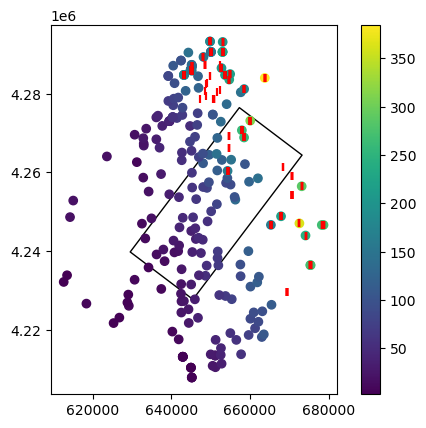

In [38]:
fig,ax=plt.subplots()
m_domain.plot(ax=ax, color='none')
gwe_grp_gpd.loc[2016, 'fall'].to_crs('epsg:32610').plot('GSE',ax=ax, legend=True)
# look at points in upper elevations as there is less data here
gwe_grp_gpd[gwe_grp_gpd.GSE>150].to_crs('epsg:32610').plot(ax=ax, color='red', marker='|')

In [19]:
# gwe_grp_gpd
# only interested in fill gaps in foothills at higher elevations (55m = 180 ft) and recent years
mtn_wells = gwe_grp_gpd[(gwe_grp_gpd.GSE>180) & (gwe_grp_gpd.year>2010)]
# mtn_wells.groupby('site_code').std()
# mtn_wells

In [20]:
# fill in missing fall-spring dates
season_dates = pd.date_range(mtn_wells.date.min(), mtn_wells.date.max(), freq='6MS')
# mtn_wells.month.unique()
# results.reindex(season_dates, fill_value=0)
# need to interpolate wells only with missing period that is bewteen dates
season_dates.shape

(22,)

In [39]:
mtn_wells.groupby('site_code').count()

,year,season,WLM_ID,WLM_RPE,WLM_GSE,GWE,GSE_GWE,STN_ID,LATITUDE,LONGITUDE,GSE,WELL_DEPTH,index_right,FID,month,date,geometry
SITE_CODE,,,,,,,,,,,,,,,,,
382586N1209949W001,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
382587N1209959W001,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
383267N1210085W001,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
383500N1209548W001,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
383500N1209595W001,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
383549N1210248W001,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
383720N1210784W001,22,22,22,22,22,18,18,22,22,22,22,22,22,22,22,22,22
384205N1210459W001,21,21,21,21,21,17,17,21,21,21,21,21,21,21,21,21,21
384397N1210158W001,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


,year,season,SITE_CODE,WLM_ID,WLM_RPE,WLM_GSE,GWE,GSE_GWE,STN_ID,LATITUDE,LONGITUDE,GSE,WELL_DEPTH,index_right,FID,month,geometry
2015-04-01,2015.0,spring,383500N1209595W001,2135862.0,268.77,267.0,256.270,10.730,50500.0,38.35,-120.96,267.0,27.0,0.0,0.0,4.0,POINT (-120.96000 38.35000)
2016-04-01,2016.0,spring,383500N1209595W001,2185642.0,268.77,267.0,257.780,9.220,50500.0,38.35,-120.96,267.0,27.0,0.0,0.0,4.0,POINT (-120.96000 38.35000)
2018-04-01,2018.0,spring,383500N1209595W001,2294057.0,268.77,267.0,256.860,10.140,50500.0,38.35,-120.96,267.0,27.0,0.0,0.0,4.0,POINT (-120.96000 38.35000)
2019-04-01,2019.0,spring,383500N1209595W001,2463242.5,268.77,267.0,258.165,8.835,50500.0,38.35,-120.96,267.0,27.0,0.0,0.0,4.0,POINT (-120.96000 38.35000)
2021-04-01,2021.0,spring,383500N1209595W001,2858414.0,268.77,267.0,255.400,11.600,50500.0,38.35,-120.96,267.0,27.0,0.0,0.0,4.0,POINT (-120.96000 38.35000)


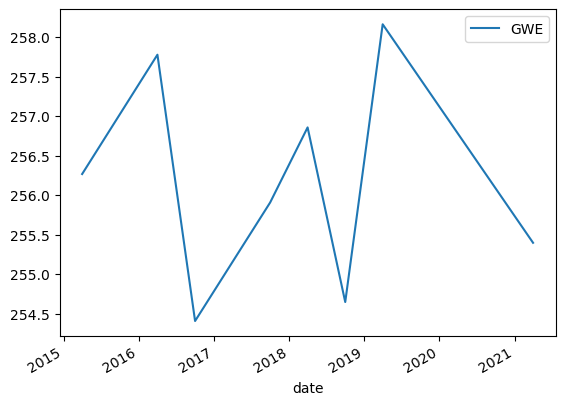

In [22]:
n = mtn_wells.site_code.unique()[1]
n= '383500N1209595W001'
gwe_site = mtn_wells.loc[mtn_wells.site_code==n]
season_dates = pd.date_range(gwe_site.date.min(), gwe_site.date.max(), freq='6MS')

# site with trend 382586N1209949W001
gwe_site.plot(kind='line', x='date',y='GWE')
gwe_site = gwe_site.set_index('date').reindex(season_dates, fill_value=None)
gwe_site[gwe_site.season=='spring']
# the missing spring or fall values could be assumed to be the average of the previous and future year


In [23]:

# for n in mtn_wells.site_code.unique()[1]:
# for each well drop measurements that are out of the average by 95th percentile
#     gwe_site = mtn_wells.loc[mtn_wells.site_code==n]
#     gwe_max = gwe_site.GWE.mean() + gwe_site.GWE.std()*0.1
#     gwe_min = gwe_site.GWE.mean() - gwe_site.GWE.std()*2
#     mtn_wells.loc[mtn_wells.site_code==n].loc[mtn_wells.loc[mtn_wells.site_code==n].GWE.values > gwe_max, 'GWE'] = np.nan
# gwe_max
# gwe_site

(100.0, 160.0)

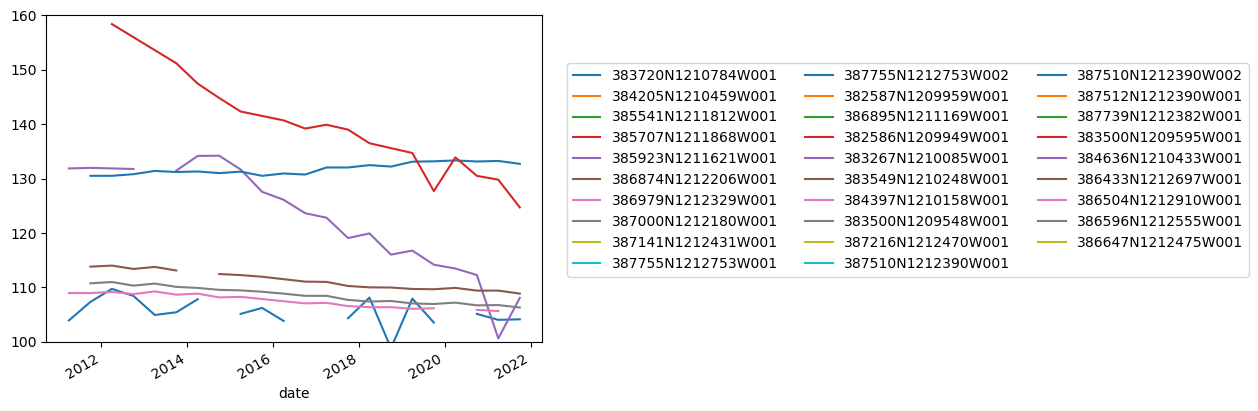

In [25]:
fig,ax=plt.subplots()
for n in mtn_wells.site_code.unique():
    mtn_wells[mtn_wells.site_code==n].plot(kind='line', x='date',y='GWE', ax=ax, legend=False, label=n)
plt.legend(loc=(1.05,0.2),ncol=3)
plt.ylim(100, 160)

In [30]:
gwe_grp_gpd[gwe_grp_gpd.year==2000].shape, gwe_grp_gpd[gwe_grp_gpd.year==2011].shape

((488, 18), (423, 18))

# Save shapefile output
**Units** of GWE are still in feet

In [47]:
# gwe_grp_gpd.columns

In [45]:
# s='spring'
# y=2021
# gwe_grp_gpd.loc[y,s].plot()
#
for s in ['spring','fall']:
#     for y in np.arange(2010,2022):
    for y in np.arange(2000,2010):
        name = s+str(y)
        fn = ghb_dir+'/Fall_Spring_GWE_Points/'+name+'_GWE_Points.shp'
        gwe_grp_gpd.loc[y,s].drop(columns=['date']).to_file(fn)

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_123900\2842106334.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gwe_grp_gpd.loc[y,s].drop(columns=['date']).to_file(fn)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_123900\2842106334.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gwe_grp_gpd.loc[y,s].drop(columns=['date']).to_file(fn)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_123900\2842106334.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gwe_grp_gpd.loc[y,s].drop(columns=['date']).to_file(fn)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_123900\2842106334.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gwe_grp_gpd.loc[y,s].drop(columns=['date']).to_file(fn)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_123900\2842106334.py:10: UserWarn

## Summary data plots

Types of WSE MSMT accuracy: ['Water level accuracy to nearest tenth of a foot' nan
 'Water level accuracy is unknown'
 'Water level accuracy to nearest hundredth of a foot'
 'Water level accuracy to nearest foot']


Text(0.5, 1.0, 'From: 2018-09-01 to 2018-11-30')

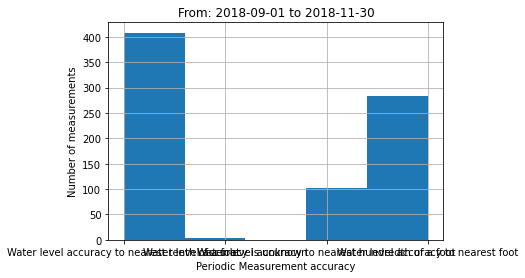

In [32]:
strt_date ='2018-09-01'
end_date = '2018-11-30'
fall2018 = domain_periodic.loc[strt_date:end_date]
pd.unique(fall2018.STN_ID).shape


domain_periodic.columns
print('Types of WSE MSMT accuracy:',fall2018.WLM_ACC_DESC.unique())
fall2018.WLM_ACC_DESC.hist(bins=len(fall2018.WLM_ACC_DESC.unique()))
plt.xlabel('Periodic Measurement accuracy')
plt.ylabel('Number of measurements')
plt.title('From: '+strt_date+' to '+end_date)

In [39]:
strt_date ='2000-01-01'
end_date = '2020-12-31'
pivot_wse_2000s = domain_periodic.loc[strt_date:end_date].pivot_table(index='msmt_date',columns='STN_ID',values='WSE')
monthly_wse_2000s = pivot_wse_2000s.resample('M').mean()


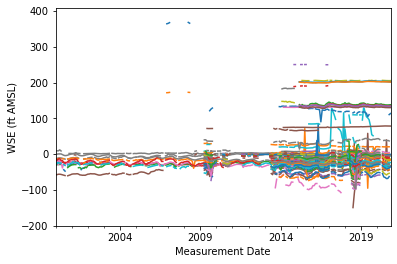

In [40]:
monthly_wse_2000s.plot(legend = False)
plt.ylim(bottom = -200)
plt.ylabel('WSE (ft AMSL)')
plt.xlabel('Measurement Date')
plt.savefig('plots/monthly__periodic_wse_2000_to_2020.png',dpi = 600, bbox_inches = 'tight')

In [112]:
strt_date ='2012-01-01'
end_date = '2019-12-31'
domain_periodic_2010s = domain_periodic.loc[strt_date:end_date]
pivot_wse_2010s = domain_periodic_2010s.pivot_table(index='msmt_date',columns='STN_ID',values='WSE')

pivot_wse_2010s = pivot_wse_2010s.resample('M').mean()


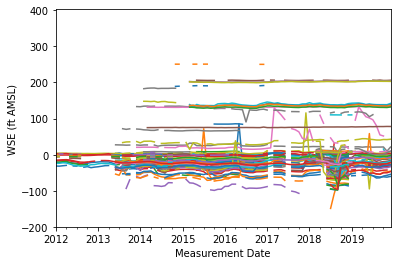

In [113]:
pivot_wse_2010s.plot(legend = False)
plt.ylim(bottom = -200)
plt.ylabel('WSE (ft AMSL)')
plt.xlabel('Measurement Date')
plt.savefig('plots/monthly__periodic_wse_2012_to_2018.png',dpi = 600, bbox_inches = 'tight')

Text(0, 0.5, 'Number of data points per month')

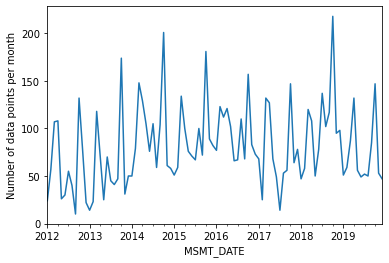

In [114]:
pivot_wse_2010s.count(axis=1).plot()
plt.ylabel('Number of data points per month')

In [115]:
monthly_wse_2010s = pd.DataFrame(monthly_wse_2010s.stack()).rename(columns={0:'WSE'})
monthly_wse_2010s = monthly_wse_2010s.reset_index()

In [202]:
# take monthly upscaled data and then rejoin that data to the dwr data based on STN_ID so that kriging can be done
# need to upscale as pivot table to avoid all station data being lumped together

# set STN_ID as index to use for joining with upscaled monthly data
monthly_stn_id = domain_periodic_2010s.set_index('STN_ID')
monthly_stn_id = monthly_stn_id.filter(['site_code','WLM_RPE','WLM_GSE','WLM_ACC','LATITUDE','LONGITUDE','geometry'],axis=1)
# drop the duplicates for multiple WSE as we are just copying the RPE, station data that doesn't change
monthly_stn_id = monthly_stn_id.drop_duplicates()

In [203]:
# monthly_stn_id has STN_ID as index, monthly_wse has it as a column
monthly_all = monthly_stn_id.join(monthly_wse_2010s.set_index('STN_ID'), on = 'STN_ID', how = 'left')


In [ ]:
monthly_all

In [205]:
monthly_all_gpd = gpd.GeoDataFrame(monthly_all, geometry = monthly_all.geometry, crs = 'epsg:32610')

In [262]:
month_dates = monthly_all_gpd.set_index('msmt_date').index.drop_duplicates().sort_values()

In [264]:
monthly_all_gpd.msmt_date

STN_ID
2006    2012-04-30
2006    2012-11-30
2006    2013-03-31
2006    2013-10-31
2008           NaT
           ...    
54351   2015-01-31
54351   2018-03-31
54351   2018-11-30
54351   2019-03-31
54351   2019-11-30
Name: MSMT_DATE, Length: 8134, dtype: datetime64[ns]

2012-02-29T00:00:00.000000000


(59, 9)

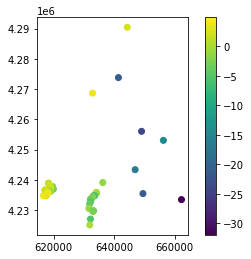

In [318]:
t=2
print(month_dates.values[t])
monthly_all_gpd.loc[monthly_all_gpd.msmt_date == month_dates.values[t]].plot('WSE', legend = True)
monthly_all_gpd.loc[monthly_all_gpd.msmt_date == month_dates.values[t]].shape

In [209]:
strt_date ='2018-08-01'
end_date = '2018-12-31'
fall2018 = domain_periodic.loc[strt_date:end_date]
pd.unique(fall2018.STN_ID).shape

(279,)

There are 808 perioidic measurement wells which is most likely due to change overtime with the wells used and the SGMA data
viewer, may be more selective with the data kept.
Between 2018-08-01 and 2018-12-31 there are still 279 unique stations with one or more measurements each. 
Only 144 wells overlapped based on site_code between the DWR CASGEM periodic measurement database and the SGMA dataviewer

<AxesSubplot:>

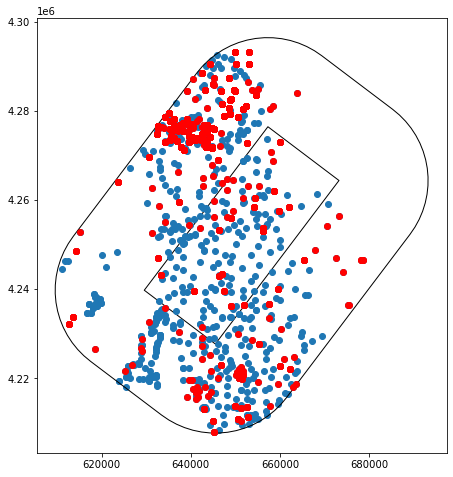

In [157]:
fig,ax= plt.subplots(figsize =(8,8))
m_domain.plot(ax=ax,edgecolor = 'black', color = 'none')

stations_gpd.plot(ax=ax)
domain_buffered.plot(ax=ax,edgecolor = 'black', color = 'none')
fall2018.plot(ax=ax, color = 'red')

2012-02-29 00:00:00


(59, 9)

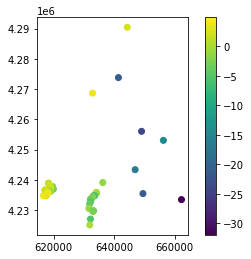

In [319]:
t=2
print(month_dates[t])
monthly_all_gpd.loc[monthly_all_gpd.msmt_date == month_dates[t]].plot('WSE', legend = True)
monthly_all_gpd.loc[monthly_all_gpd.msmt_date == month_dates[t]].shape

In [320]:
df = monthly_all_gpd.loc[monthly_all_gpd.msmt_date == month_dates[t]]

In [326]:
df.shape
df.drop_duplicates()

,SITE_CODE,WLM_RPE,WLM_GSE,WLM_ACC,LATITUDE,LONGITUDE,geometry,MSMT_DATE,WSE
STN_ID,,,,,,,,,
8581,385567N1214751W001,27.62,26.82,Unknown,38.5567,-121.475,POINT (632875.984 4268687.305),2012-02-29,4.02
9641,386016N1213761W001,66.70,67.50,Unknown,38.6016,-121.376,POINT (641414.442 4273817.790),2012-02-29,-21.40
13659,387511N1213389W001,143.72,143.42,Unknown,38.7511,-121.339,POINT (644335.872 4290466.231),2012-02-29,2.52
26720,382346N1211464W001,108.33,107.33,Unknown,38.2346,-121.146,POINT (662263.020 4233469.962),2012-02-29,-31.97
27447,383264N1213191W001,48.50,48.10,Unknown,38.3264,-121.319,POINT (646935.684 4243367.698),2012-02-29,-16.90
27987,382548N1212908W001,53.22,52.22,Unknown,38.2548,-121.291,POINT (649530.219 4235467.224),2012-02-29,-21.18
28812,382899N1214415W001,15.38,14.88,Unknown,38.2899,-121.442,POINT (636251.940 4239128.865),2012-02-29,-1.22
40043,384403N1212921W002,80.88,79.38,Unknown,38.4403,-121.292,POINT (649061.882 4256050.566),2012-02-29,-24.02
49350,382593N1214664W001,14.67,11.02,10 ft.,38.2593,-121.466,POINT (634209.273 4235698.183),2012-02-29,-2.03
